# Predicting Water Pump Functionality in Tanzania (HydroLogic Project)
Authored by Farzaneh Gerami, Subaye Opoku-Acquah & Mariam Farda | 
March – June 2025

# Imports

In [441]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import f_oneway

import math

import datetime

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency, ttest_ind # checking if the data is random or depends on other

import joblib


# Sprint 1 & 2 - Feature Engineering

## Read numerical Dataset

In [442]:
# Read Merged data as an original data
df_train = pd.read_csv('../data/processed/Cleaned_numerical_dataset.csv')
df_train.head()

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,public_meeting,permit,construction_year,...,wpt_name_Other,wpt_name_School,wpt_name_Sekondari,wpt_name_Shule,wpt_name_Shule Ya Msingi,wpt_name_Shuleni,wpt_name_Sokoni,wpt_name_Upendo,wpt_name_Zahanati,wpt_name_none
0,6000.0,1390.0,34.938093,-9.856322,11,5,109.0,1,0,1999,...,0,0,0,0,0,0,0,0,0,1
1,0.0,1399.0,34.698766,-2.147466,20,2,280.0,0,1,2010,...,0,0,0,0,0,0,0,0,1,0
2,25.0,686.0,37.460664,-3.821329,21,4,250.0,1,1,2009,...,1,0,0,0,0,0,0,0,0,0
3,0.0,263.0,38.486161,-11.155298,90,63,58.0,1,1,1986,...,1,0,0,0,0,0,0,0,0,0
4,0.0,0.0,31.130847,-1.825359,18,1,0.0,1,1,1996,...,0,0,0,0,0,1,0,0,0,0


In [443]:
df_train.shape

(47520, 248)

we need to look at the uniques of the columns and group them. specially because they are nominal

In [444]:
print(df_train.columns)


Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'public_meeting', 'permit',
       'construction_year',
       ...
       'wpt_name_Other', 'wpt_name_School', 'wpt_name_Sekondari',
       'wpt_name_Shule', 'wpt_name_Shule Ya Msingi', 'wpt_name_Shuleni',
       'wpt_name_Sokoni', 'wpt_name_Upendo', 'wpt_name_Zahanati',
       'wpt_name_none'],
      dtype='object', length=248)


## checking data type

In [445]:
df_train.dtypes

amount_tsh           float64
gps_height           float64
longitude            float64
latitude             float64
region_code            int64
                      ...   
wpt_name_Shuleni       int64
wpt_name_Sokoni        int64
wpt_name_Upendo        int64
wpt_name_Zahanati      int64
wpt_name_none          int64
Length: 248, dtype: object

## Seperate features and target

In [446]:
X = df_train.drop(columns=['status_group'])  # all features
y = df_train['status_group']                # target


## Identify columns types

In [447]:
bool_cols = []  # already converted to int, no need to separate
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
object_cols = X.select_dtypes(include='object').columns.tolist()

# Year-like features that we'll scale separately (or include in numeric)
date_like = [col for col in X.columns if any(k in col.lower() for k in ['year', 'month', 'day'])]

# Print each group (for verification)
print("Boolean Columns:", bool_cols)
print("Numeric Columns:", numeric_cols)
print("Categorical (Object) Columns:", object_cols)

Boolean Columns: []
Numeric Columns: ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'public_meeting', 'permit', 'construction_year', 'year_recorded', 'month_recorded', 'dayofweek_recorded', 'quality_group_encoded', 'quantity_encoded', 'status_group_encoded', 'management_other', 'management_other - school', 'management_parastatal', 'management_private operator', 'management_trust', 'management_unknown', 'management_vwc', 'management_water authority', 'management_water board', 'management_wua', 'management_wug', 'scheme_name_Borehole', 'scheme_name_Chalinze wate', 'scheme_name_DANIDA', 'scheme_name_Government', 'scheme_name_Handeni Trunk Main(H', 'scheme_name_I', 'scheme_name_K', 'scheme_name_Kijiji', 'scheme_name_Kirua kahe gravity water supply trust', 'scheme_name_Losaa-Kia water supply', 'scheme_name_M', 'scheme_name_Machumba estate pipe line', 'scheme_name_Makwale water supplied sche', 'scheme_name_N', 'scheme_name_Ngana water supp

In [448]:
numeric_cols = [col for col in numeric_cols if col not in date_like]


## Define pipeline for each

In [449]:
# Numeric: median imputation + scaling
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Date-like: fill with 0 + scaling
date_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# Categorical: fill with mode + one-hot encode
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


## combine in a ColumnTransformer

In [450]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_cols),
    ('date', date_pipeline, date_like),
    ('cat', categorical_pipeline, object_cols)
], remainder='passthrough')  # In case you have extras like bools-as-int


## Full Pipeline with Classifier

In [451]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

## Fit  pipeline

In [452]:
pipeline.fit(X, y)


MemoryError: Unable to allocate 87.0 MiB for an array with shape (47520, 240) and data type float64

In [ ]:
X_transformed = pipeline.named_steps['preprocessing'].transform(X)


In [ ]:
from sklearn.compose import make_column_selector as selector

# Extract OneHotEncoder
ohe = pipeline.named_steps['preprocessing'].named_transformers_['cat'].named_steps['encoder']

# Use appropriate method based on sklearn version
try:
    ohe_features = ohe.get_feature_names_out(object_cols)
except AttributeError:
    ohe_features = ohe.get_feature_names(object_cols)
    ohe_features = [f.decode('utf-8') if isinstance(f, bytes) else f for f in ohe_features]

# All column names (numerics + date + encoded categoricals)
all_features = numeric_cols + date_like + list(ohe_features)

# Transform X
X_transformed = pipeline.named_steps['preprocessing'].transform(X)

# Convert to DataFrame
X_transformed_df = pd.DataFrame(X_transformed.toarray() if hasattr(X_transformed, "toarray") else X_transformed,
                                columns=all_features)


MemoryError: Unable to allocate 14.4 GiB for an array with shape (47520, 40686) and data type float64

In [ ]:
print(X_transformed_df.dtypes)


NameError: name 'X_transformed_df' is not defined

## I have to check if all are numerical and then do the MI

In [ ]:
df_train.dtypes

amount_tsh               float64
funder                    object
gps_height               float64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population               float64
public_meeting             int32
scheme_management         object
scheme_name               object
permit                    object
construction_year        float64
extraction_type_class     object
management                object
management_group          object
payment_type              object
water_quality             object
quality_group             object
quantity                  object
source                    object
source_class              object
waterpoint_type           object
status_gro

In [ ]:
X = df_train.drop(columns='status_group')
y = df_train['status_group']

# Identify categorical features (object types)
categorical_mask = X.dtypes == object

# Encode categorical features using .cat.codes
X_encoded = X.copy()
for col in X.columns[categorical_mask]:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes


In [ ]:
df_train['construction_year'] = pd.to_numeric(df_train['construction_year'], errors='coerce')


In [ ]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(
    X_encoded, y,
    discrete_features=categorical_mask.values,
    random_state=0
)

mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi
}).sort_values(by='Mutual Information', ascending=False)

print(mi_df)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Mutual Information

In [ ]:
X = df_train.drop(columns='status_group')
y = df_train['status_group']

# Identify categorical features (object types)
categorical_mask = X.dtypes == object

# Encode categorical features using .cat.codes
X_encoded = X.copy()
for col in X.columns[categorical_mask]:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes


In [ ]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(
    X_encoded, y,
    discrete_features=categorical_mask.values,
    random_state=0
)

mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi
}).sort_values(by='Mutual Information', ascending=False)

print(mi_df)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
df_train['construction_year'] = pd.to_numeric(df_train['construction_year'], errors='coerce')


In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI sc

ValueError: could not convert string to float: '2011-03-14'

Interpretation: Each value in the output tells us how much information that feature contributes to predicting the target. Higher values = more useful for prediction.

## plot it

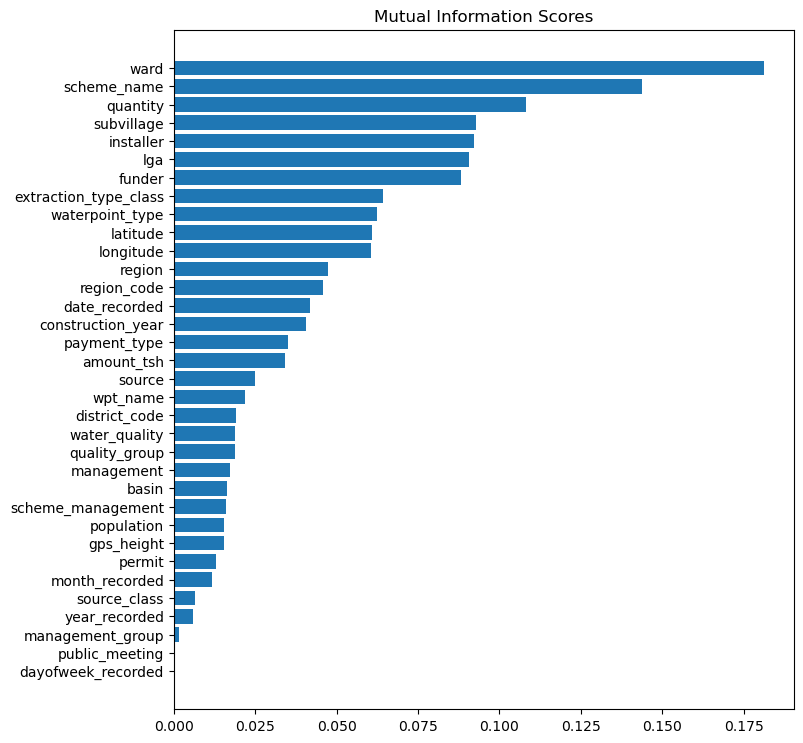

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 9))
plot_mi_scores(mi_scores)